In [1]:
# Initial setup of copula generative model based on parametric distributions for larger set of variables
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 3/11/2022
#          v2 First draft with all components for nonparametric experiment for continuous case 3/14/2022
#          v3 Draft with updates for hosting on GitHub 4/30/2022
#
# References:
#   -https://openturns.github.io/openturns/latest/theory/probabilistic_modeling/copulas.html#copula
#   -https://openturns.github.io/openturns/latest/auto_probabilistic_modeling/copulas/plot_composed_copula.html
#   -https://en.wikipedia.org/wiki/Copula_(probability_theory)

# Nonparametric Order Reduction Using Canonical Problem

This notebook examines the ability to use the order reduction techniques to find a data-based basis of reduced dimensionality for the data generated using the marginal+copula joint distribution (generative model) that was set up to match the characteristics of the distributions expected in the outputs from agent-based simulation

In [53]:
# probabilistic and statistical modeling
import openturns as ot
import openturns.viewer as viewer
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as st
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

# data and numerical functions
import numpy as np
import pandas as pd

# graphing and visualization functions
import matplotlib.pyplot as plt
import seaborn as sns

# order reduction and data conditioners
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

# design of experiments
from doepy import build

# os operations
import os as os
import sys
import datetime as dt
import pickle
from joblib import dump, load

# custom functions
import stats_functions as sf
import copula_gen_data as cpgen

In [4]:
# directory setup

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'nonparOR' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\nonparOR20220502094726


In [12]:
# set up emulator

# defining objects here, to be moved to module later

# Simulation class
class Simulation:
    """
    Object defining the joint distribution which represents an instance of a simulation

    Attributes
    ----------
    param_vals : np.array
        input values based on simulation configuration (subset of all_param_vals)
    all_param_vals : np.array
        all values used to setup the specifics of the simulation
    corr_rng_seed :
        value to use as the seed for setting up the correlation matrix
    distribution_types : list of strings
        list of the specific types of distributions to be used
    marginals : list of ot distributions
        list of the ot distribution objects that define the marginal distributions
    correlation_matrix : ot.CorrelationMatrix
        correlation matrix between marginals
    copula : ot.NormalCopula
        Gaussian copula created based on the correlation matrix between marginals
    joint_distribution : ot.ComposedDistribution
        the main element of the simulation, combines the marginals through the copula

    Methods
    -------


    """
    def __init__(self, input_vals, corr_rng_seed):
        self.input_vals = input_vals
        self.param_vals = []
        self.all_param_vals = []
        self.corr_rng_seed = corr_rng_seed
        self.distribution_types = []
        self.marginals = []
        self.correlation_matrix = None
        self.copula = None
        self.joint_distribution = None

    def update_parameter_values(self):
        """set the values of the input parameters for the simulation"""
        input_params = self.input_vals
        param_list = [[input_params[4] * input_params[7], 3.0], [input_params[5] * 0.8, 10.0],
                      [input_params[0],100.0], [-350.0,input_params[5]+10.*input_params[6]],
                      [input_params[11]+0.3,0.3], [0.1*input_params[0], 1.2*input_params[1]],
                      [input_params[-2], 3.0], [35000.0, input_params[1]], [input_params[-3]*4., 3.9],
                      [-1.5, 1.0, 1.5, 1.0, 1.0 - input_params[4], input_params[4]],
                      [input_params[2], 1.0, 5, 3.0, 0.5, 0.5],
                      [55.0*input_params[4], 5.0, 85.0, 5.0, input_params[3], 1.0 - input_params[3]],
                      [input_params[4]**2, 0.1, 0.9, 0.25, 0.5, 0.5], [input_params[4],1.0],
                      [input_params[-5]*0.5,0.6], [35.0,input_params[5]], [3.0*input_params[6]-1.5,3.1],
                      [input_params[6], 0.5, -1.0, 1.0], [5.0, 1.0*input_params[6], -1.0, 1.0],
                      [2.0, input_params[7], -1.0, 1.0], [input_params[7], 5.0, -1.0, 1.0],
                      [input_params[8], 2.0], [1.0*input_params[6], 2.0], [1.5, 3.0*input_params[6]],
                      [1.5, input_params[9]], [20, input_params[10]], [30, input_params[11]],
                      [input_params[12], 2.], [1, input_params[13]], [input_params[14]]]
        self.param_vals = param_list

    def update_distribution_types(self):
        """Create or replace the list of types of distributions to be included in marginals;
        potentially an input in the future, for now, static
        """
        dist_types = ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian',
                      'gaussian', 'gaussian', 'gaussian', 'gaussmix', 'gaussmix', 'gaussmix',
                      'gaussmix', 'uniform', 'uniform', 'uniform', 'uniform', 'beta',
                      'beta', 'beta', 'beta', 'gumbel', 'gumbel', 'gumbel',
                      'gumbel', 'binomial', 'binomial', 'skellam', 'skellam', 'poisson']
        self.distribution_types = dist_types

    def update_marginals(self):
        """Use the param values to fill out the list of marginal distributions"""
        # first, put specific inputs into distribution parameters list
        self.update_parameter_values()
        # then, list all the types of marginal distributions to create
        self.update_distribution_types()
        # then, for each dist_type : param_values pair, create the corresponding ot distribution
        for (vals, name) in zip(self.param_vals, self.distribution_types):
            if name == 'gaussian':
                self.marginals.append(ot.Normal(vals[0], vals[1]))
            elif name == 'gaussmix':
                mix_margs = [ot.Normal(vals[0], vals[1]), ot.Normal(vals[2], vals[3])]
                mix_weights = [vals[4], vals[5]]
                self.marginals.append(ot.Mixture(mix_margs, mix_weights))
            elif name == 'uniform':
                self.marginals.append(ot.Uniform(vals[0], vals[1]))
            elif name == 'beta':
                self.marginals.append(ot.Beta(vals[0], vals[1], vals[2], vals[3]))
            elif name == 'gumbel':
                self.marginals.append(ot.Gumbel(vals[0], vals[1]))
            elif name == 'binomial':
                self.marginals.append(ot.Binomial(int(vals[0]), vals[1]))
            elif name == 'skellam':
                self.marginals.append(ot.Skellam(vals[0], vals[1]))
            elif name == 'poisson':
                self.marginals.append(ot.Poisson(vals[0]))
            else:
                print('Unexpected distribution name')
                self.marginals.append(ot.Normal(0, 1))

    def update_correlation_matrix(self):
        """Use the input random seed and shape of marginals to create the correlation matrix"""
        # requires marginals to be created first
        rng = np.random.default_rng(seed=self.corr_rng_seed)
        num_distributions = len(self.marginals)
        corr_samp = rng.uniform(low=0.0001, high=1.0, size=num_distributions)
        norm_corr_samp = corr_samp / (sum(corr_samp))
        local_corr_mat = norm_corr_samp * float(num_distributions)
        rand_corr_mat = st.random_correlation.rvs(local_corr_mat, random_state=rng)
        self.correlation_matrix = ot.CorrelationMatrix(num_distributions, rand_corr_mat.flatten())

    def update_copula(self):
        """Use the correlation matrix to update the copula object for the simulation"""
        self.update_correlation_matrix()
        self.copula = ot.NormalCopula(self.correlation_matrix)

    def update_joint_distribution(self):
        """Use the marginals and copula to update the joint distribution for the simulation"""
        # create ot distributions for the marginals
        self.update_marginals()
        # create an ot copula to connect the ot distributions
        self.update_copula()
        # combine into a joint distribution
        self.joint_distribution = ot.ComposedDistribution(self.marginals, self.copula)

    def reset_simulation(self):
        """Remove setup of simulation to avoid appending duplicates"""
        self.marginals = []

    def get_joint_distribution_samples(self, n_samples=1000):
        """Get the specified number of random samples from the joint distribution that
        defines the simulation
        """
        self.reset_simulation()
        self.update_joint_distribution()
        samples = np.array(self.joint_distribution.getSample(n_samples))
        return samples

In [13]:
x_in = np.array([1000., 6500., -1.0, 0.2, 0.2, 45., 1.2, 3.0, 0.6, 2.2, 0.7, 0.6, 12., 8., 2.])

In [14]:
sim_ex = Simulation(x_in, 42)

In [17]:
%%time
ex_samples = sim_ex.get_joint_distribution_samples(1000)

CPU times: total: 219 ms
Wall time: 28 ms


In [60]:
# Data class

class Data:
    """
    Object to hold different versions of data generated from multiple simulation calls
    -conditions and converts to fill out required data types for Experiment
    -path1: starts from samples and fills out other types
    -path2: starts from ecdf_x and fills out other types

    Attributes
    ----------
    scaled_ecdfs : tuple( ecdfy : np.array 1d, ecdfx : np.array 3d)

    Methods
    -------

    """
    def __init__(self, samples=None, ecdf_vals=None, custom_bins=None, custom_scaler=None, discrete_flags=None):
        self.samples = samples
        self.custom_bins = custom_bins
        self.custom_scaler = custom_scaler
        self.scaler = None
        self.scaled_samples = None
        self.scaled_epdfs = None
        self.scaled_ecdfs = ecdf_vals
        self.discrete_flags = discrete_flags

    def round_samples(self):
        """Round the samples which correspond to discrete distributions (assuming all discrete as int)
        -requires samples set up"""
        if self.discrete_flags is not None:
            list_of_dist_data = np.split(self.samples, axis=2)
            rounded_data_list = []
            for (flag, data_slice) in zip(self.discrete_flags, list_of_dist_data):
                if flag:
                    data_slice = np.around(data_slice)
                rounded_data_list.append(data_slice)
            self.samples = np.stack(rounded_data_list, axis=2)

    def scale_samples(self):
        """Scale samples based on custom scaler input or else sklearn StandardScaler - requires samples set up"""
        if self.custom_scaler is None:
            # use new sklearn standard scaler
            self.scaler = StandardScaler()
            # format to scale across full parametric dataset (scale to the full range)
            samples_formatted_for_scaler = cpgen.format_data_for_global_scaler(self.samples)
            self.scaler.fit(samples_formatted_for_scaler)
            scaled_samples_in_scaler_format = self.scaler.transform(samples_formatted_for_scaler)
            # reformat back to back shape
            self.scaled_samples = cpgen.reshape_data_after_scaling(scaled_samples_in_scaler_format,
                                                                   self.samples.shape[0])
        else:
            self.scaler = self.custom_scaler
            samples_formatted_for_scaler = cpgen.format_data_for_global_scaler(self.samples)
            scaled_samples_in_scaler_format = self.scaler.transform(samples_formatted_for_scaler)
            self.scaled_samples = cpgen.reshape_data_after_scaling(scaled_samples_in_scaler_format,
                                                                   self.samples.shape[0])

    def get_scaled_ecdfs_from_samples(self):
        """Transform scaled samples into ecdf format - requires scaled samples set up"""
        ecdf_y = sf.get_ecdf_y(self.scaled_samples[0,:,0])
        ecdf_x = np.apply_along_axis(sf.get_ecdf_x, axis=1, arr=self.scaled_samples)
        self.scaled_ecdfs = (ecdf_y, ecdf_x)

    def get_scaled_epdfs_from_samples(self):
        """Transform scaled samples into epdf format - requires scaled samples set up"""
        if self.custom_bins is None:
            # determine bins from scaled_samples and hardcoded total number of bins
            num_bins = 50
            epdf_bins = np.apply_along_axis(sf.get_epdf_bins, arr=self.scaled_samples, bins=num_bins, axis=1)
            epdf_probs = np.apply_along_axis(sf.get_epdf_probs, arr=self.scaled_samples, bins=num_bins, axis=1)
        else:
            # bins are given
            bins_to_use = self.custom_bins
            epdf_bins = np.zeros_like(self.scaled_samples)
            epdf_probs = np.zeros_like(self.scaled_samples)
            for i in range(epdf_bins.shape[0]):
                for j in range(epdf_bins.shape[2]):
                    bins = bins_to_use[i,:,j]
                    epdf_bins = bins
                    epdf_probs = sf.get_epdf_probs(arr=self.scaled_samples[i,:,j], bins=bins)
        self.scaled_epdfs = (epdf_bins, epdf_probs)

    def data_setup_from_samples(self):
        """Perform operations to flesh out data starting from a set of samples"""
        # assuming samples already rounded
        self.scale_samples()
        self.get_scaled_ecdfs_from_samples()
        self.get_scaled_epdfs_from_samples()

    def data_setup_from_ecdfs(self):
        """Perform operations to flesh out data starting from a set of ecdfs"""
        raw_ecdf_x_vals = self.scaled_ecdfs[1]
        conditioned_ecdf_vals = np.apply_along_axis(sf.get_monotonic_ecdf_aprox, axis=1, arr=raw_ecdf_x_vals)
        example_ecdf_y = sf.get_ecdf_y(conditioned_ecdf_vals[0,:,0])
        undiscretized_samples = np.apply_along_axis(sf.sample_ecdf, arr=conditioned_ecdf_vals,
                                                    axis=1, num_samples=conditioned_ecdf_vals.shape[1],
                                                    ecdfy=example_ecdf_y)
        # round the discrete samples
        self.samples = undiscretized_samples
        self.round_samples()
        # update the ecdfx values for the discrete distributions
        # todo - specify only the discrete ecdfs to get updated and leave the continuous ones
        self.get_scaled_ecdfs_from_samples()
        self.get_scaled_epdfs_from_samples()



In [19]:
ex_samples1 = sim_ex.get_joint_distribution_samples(1000)
ex_samples2 = sim_ex.get_joint_distribution_samples(1000)
sampleset_ex = np.stack([ex_samples1, ex_samples2], axis=0)

discrete_flags = []
for i in range(25):
    discrete_flags.append(False)
for i in range(5):
    discrete_flags.append(True)

data_ex = Data(samples=sampleset_ex, discrete_flags=discrete_flags)

In [20]:
%%time
data_ex.data_setup_from_samples()

CPU times: total: 31.2 ms
Wall time: 37 ms


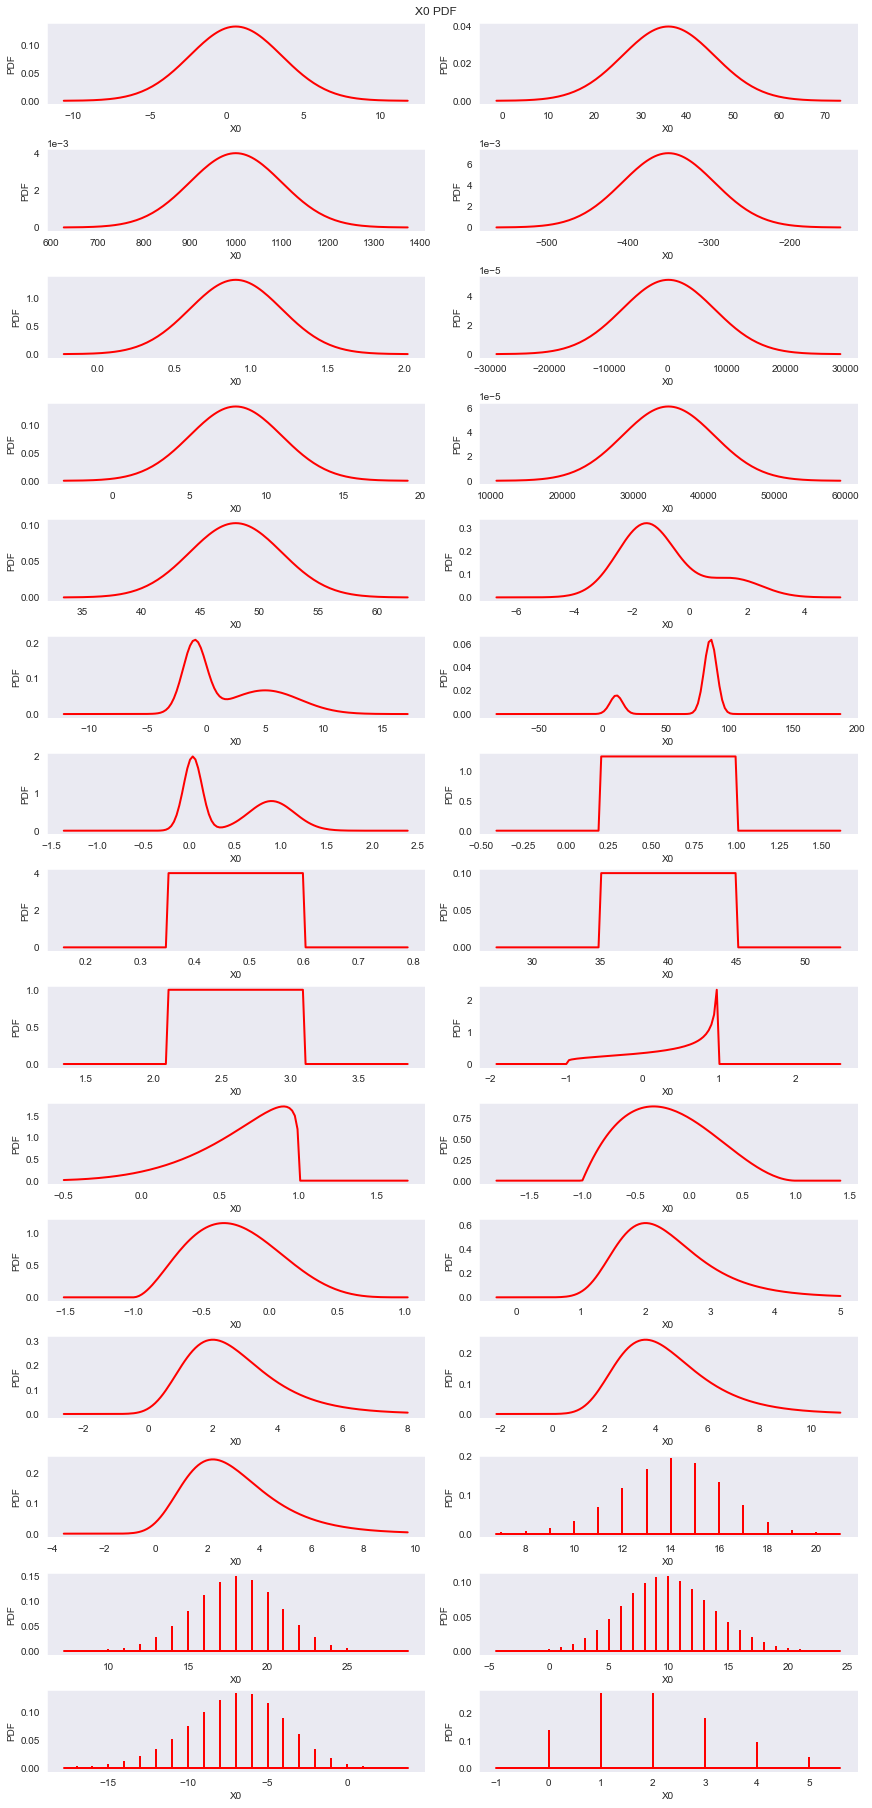

In [61]:
# non-parametric OR notebook ------

# generate data for non-parametric OR experiment
x_in = np.array([1000., 6500., -1.0, 0.2, 0.2, 45., 1.2, 3.0, 0.6, 2.2, 0.7, 0.6, 12., 8., 2.])
single_sim = Simulation(x_in, 42)
sample_set = single_sim.get_joint_distribution_samples(1000)
dists = single_sim.marginals

# plot the true marginal distributions
fig1, ax1 = plt.subplots(15, 2, figsize=(12,25), constrained_layout=True)
ax = ax1.ravel()
for i in range(0,len(dists)):
    pdfdraw = dists[i].drawPDF()
    pdfview = ot.viewer.View(pdfdraw,axes=ax[i:])
    ax[i].get_legend().remove()
    ax[i].grid(visible=False)

In [63]:
# convert data to formats for analysis
data = Data(samples=np.expand_dims(sample_set, axis=0))
data.data_setup_from_samples()

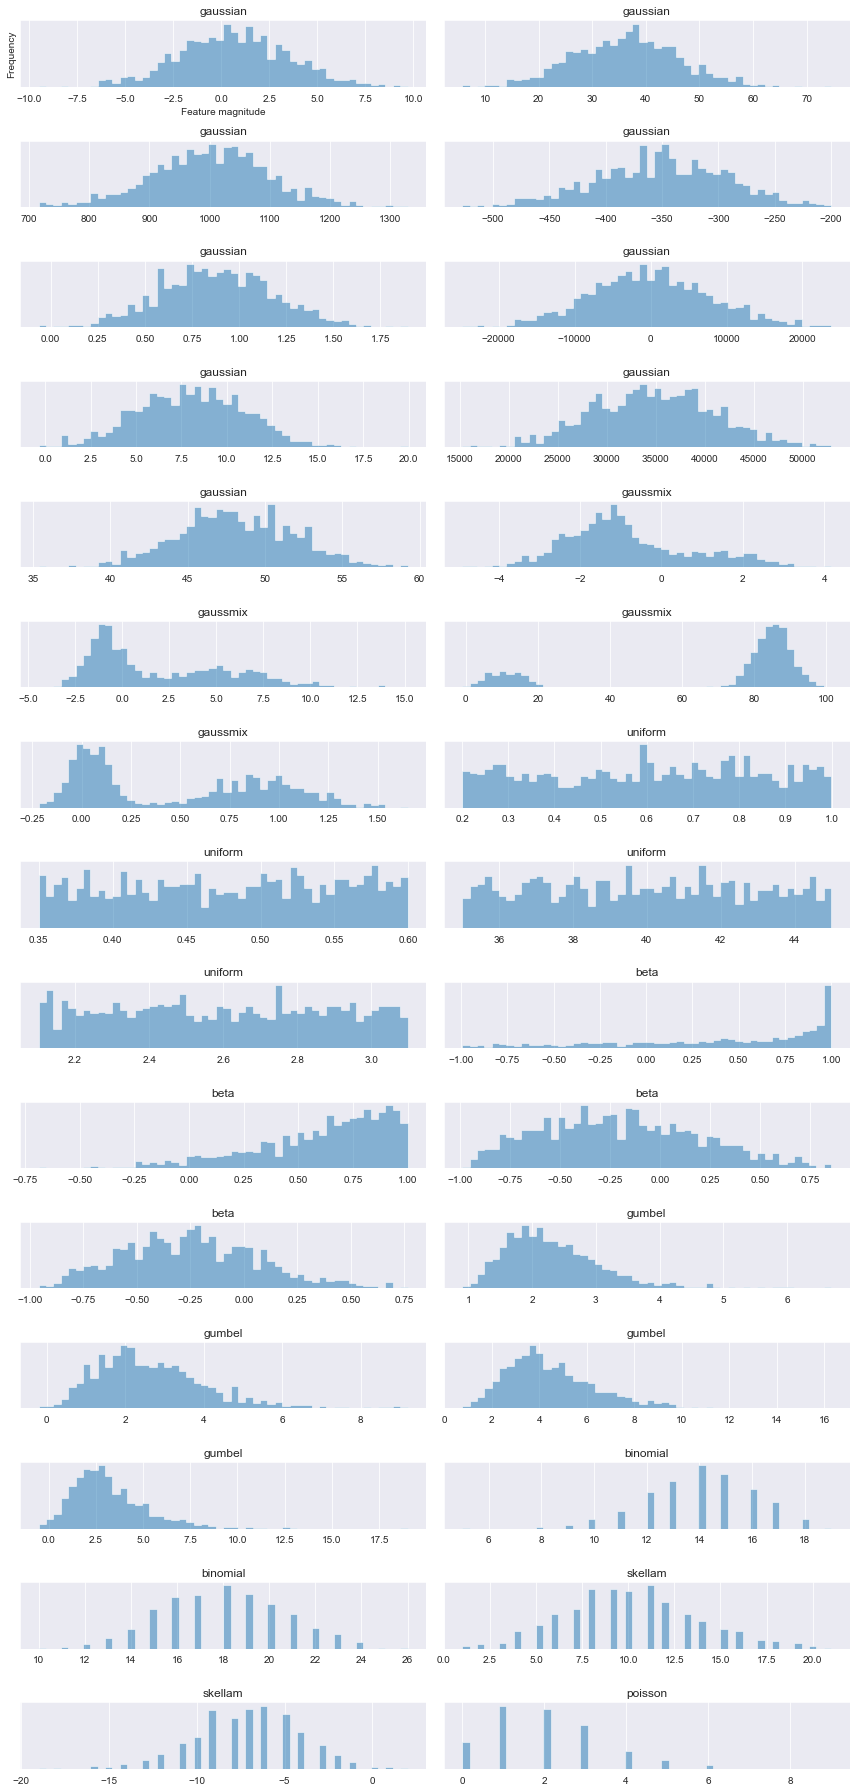

In [64]:
# take a look at plots of the samples (without scaling)
fig2, ax2 = plt.subplots(15, 2, figsize=(12,25))
ax = ax2.ravel()
for i in range(data.samples.shape[2]):
    _, bins = np.histogram(data.samples[0,:,i], bins=50)
    ax[i].hist(data.samples[0,:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig2.tight_layout()

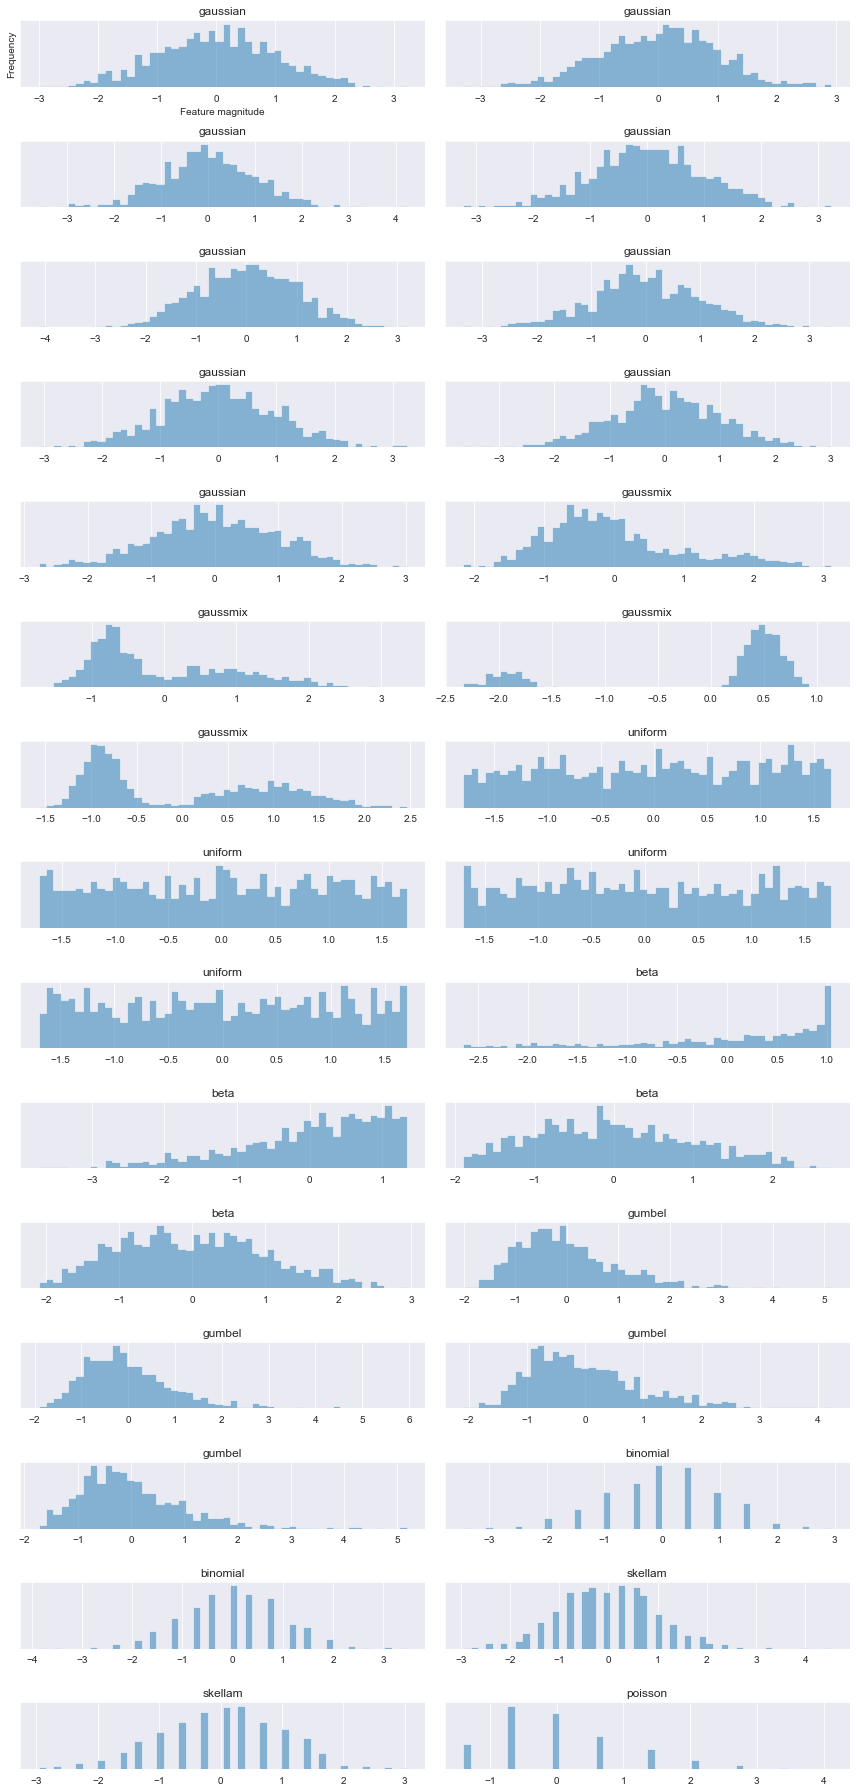

In [35]:
# take a look at plots of the samples (with scaling)
fig3, ax3 = plt.subplots(15, 2, figsize=(12,25))
ax = ax3.ravel()
for i in range(data.scaled_samples.shape[2]):
    _, bins = np.histogram(data.scaled_samples[0,:,i], bins=50)
    ax[i].hist(data.scaled_samples[0,:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig3.tight_layout()

Feature  0  compared to  0 stat: 1.000, pval: 0.000
Feature  0  compared to  1 stat: -0.140, pval: 0.000
Feature  0  compared to  2 stat: 0.060, pval: 0.059
Feature  0  compared to  3 stat: 0.057, pval: 0.072
Feature  0  compared to  4 stat: 0.024, pval: 0.440
Feature  0  compared to  5 stat: 0.001, pval: 0.975
Feature  0  compared to  6 stat: 0.031, pval: 0.323
Feature  0  compared to  7 stat: -0.144, pval: 0.000
Feature  0  compared to  8 stat: 0.239, pval: 0.000
Feature  0  compared to  9 stat: 0.209, pval: 0.000
Feature  0  compared to  10 stat: -0.130, pval: 0.000
Feature  0  compared to  11 stat: 0.015, pval: 0.634
Feature  0  compared to  12 stat: -0.029, pval: 0.360
Feature  0  compared to  13 stat: 0.077, pval: 0.015
Feature  0  compared to  14 stat: -0.037, pval: 0.238
Feature  0  compared to  15 stat: -0.009, pval: 0.781
Feature  0  compared to  16 stat: 0.034, pval: 0.284
Feature  0  compared to  17 stat: 0.012, pval: 0.711
Feature  0  compared to  18 stat: -0.147, pval: 0.

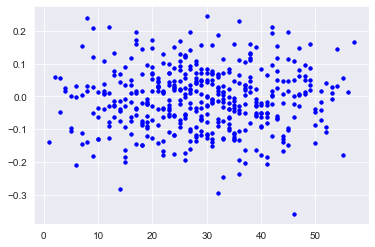

In [37]:
# check the correlation in the dataset
fig3, ax3 = plt.subplots(1,1)
for i in range(0, data.scaled_samples.shape[2]):
    for j in range(0,data.scaled_samples.shape[2]):
        corr_test = pearsonr(data.scaled_samples[0,:,i], data.scaled_samples[0,:,j])
        print('Feature ', i, ' compared to ', j, 'stat: %.3f, pval: %.3f' % (corr_test[0], corr_test[1]))
        if i != j:
            plt.scatter(i+j,corr_test[0],marker='.',c='b')

In [39]:
# test PCA approach

# first directly with samples
data_pca = data.scaled_samples[0]
req_ric = 0.99
pca = PCA(req_ric)
pca.fit(data_pca)
print('Number of components needed for retaining ', req_ric, ' RIC: ', pca.n_components_)
X_pca = pca.transform(data_pca)
print("Original shape: {}".format(str(data_pca.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
X_pca_plot = pd.DataFrame(X_pca)

Number of components needed for retaining  0.99  RIC:  28
Original shape: (1000, 30)
Reduced shape: (1000, 28)


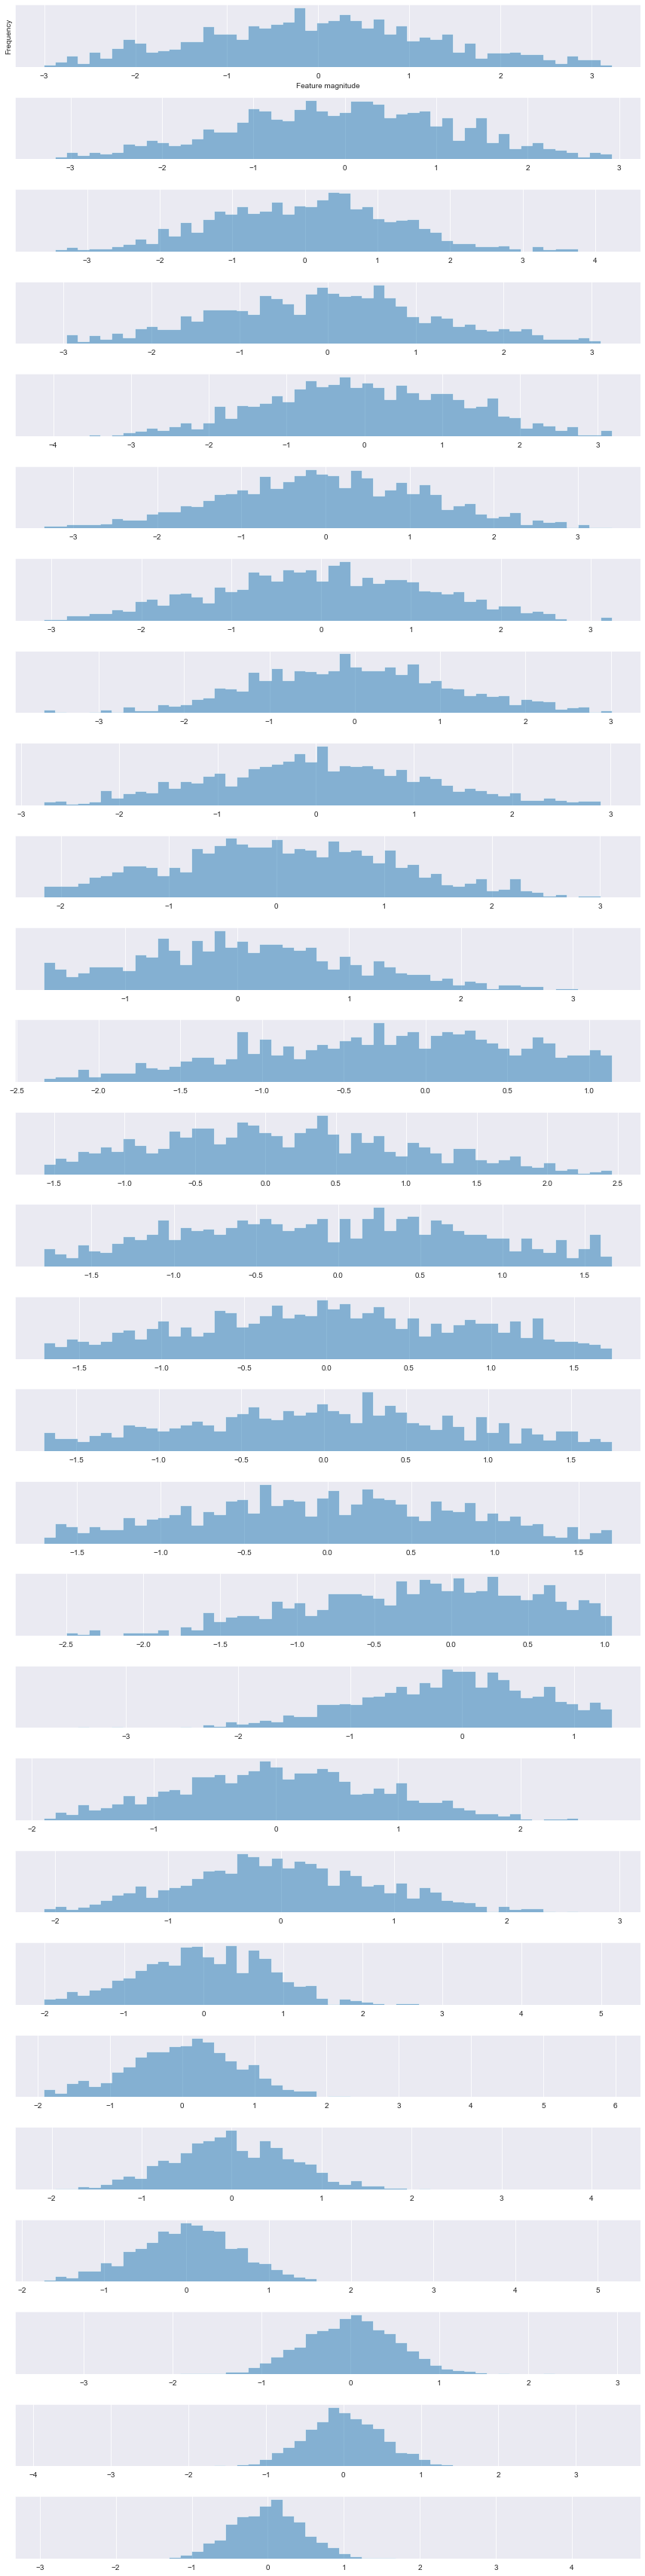

In [40]:
# plotting latent space data
# plotting scaled data
fig4, ax4 = plt.subplots(pca.n_components_, 1, figsize=(12,1.7*pca.n_components_))
ax = ax4.ravel()
for i in range(pca.n_components_):
    # use original bins
    _, bins = np.histogram(data_pca[:, i], bins=50)
    ax[i].hist(X_pca_plot.iloc[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig4.tight_layout()

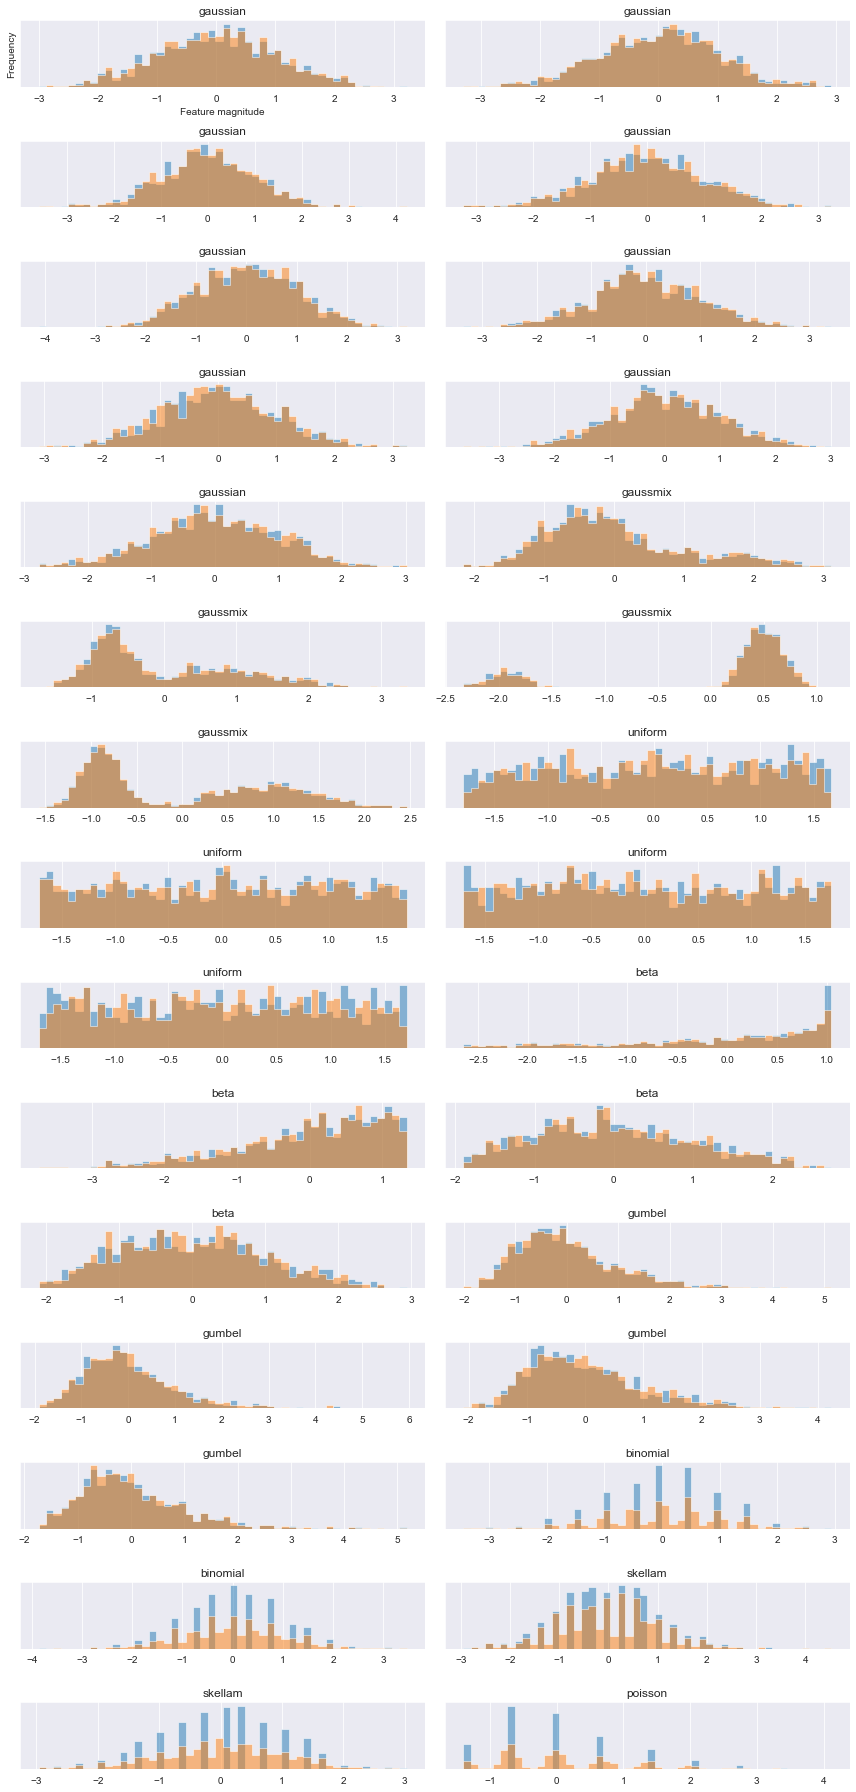

In [41]:
# plot comparison

# true distribution samples
X_plot_true = data_pca
# approximation with order reduction
X_pca_approx = pca.inverse_transform(X_pca)
# X_kpca_approx = kernel_pca.inverse_transform(X_kpca)

X_plot_approx = X_pca_approx

# take a look at plots of the samples (without scaling)
fig7, ax7 = plt.subplots(15, 2, figsize=(12,25))
ax = ax7.ravel()
for i in range(data_pca.shape[1]):
    _, bins = np.histogram(data_pca[:, i], bins=50)
    ax[i].hist(X_plot_true[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].hist(X_plot_approx[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig7.tight_layout()

# note that rounding not included here...

In [42]:
# helper functions for creating epdfs

# set up an empirical probability mass/density function as a probability array
def epdf(samp, n=22, density=True):
    if density is True:
        h, e = np.histogram(samp, bins=n, density=density)
        p = h
    else:
        h, e = np.histogram(samp, bins=n, density=density)
        p = h / sum(h)
    return e, p

# enforce properties of probability arrays needed to calculate KL and JS metrics
def support_intersection(p, q):
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

# separate tuple into two arrays
def get_probs(list_of_tuples):
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

# condition data arrays and use scipy JS distance function
def compute_js_dist(p, q):
    """Take as input p and q as epdfs with the same edge values
    # check for and discard inconsistent data based on zeros"""
    temp = support_intersection(p,q)
    pn, qn = get_probs(temp)
    return jensenshannon(pn, qn)

# condition data arrays and use scipy KL divergence function - via entropy
def compute_kl_dist(p, q):
    temp = support_intersection(p,q)
    pn, qn = get_probs(temp)
    return st.entropy(pn, qn)

In [43]:
# structured data case

# initial data
x_true = data_pca
x_approx = X_pca_approx

# calculate epdfs to structure data
# holders
x_t_epdfs = []
x_a_epdfs = []
x_t_ecdfs = []
x_a_ecdfs = []
epdf_bins = []

# calculate
for i in range(0,x_true.shape[1]):
    _, bins = np.histogram(x_true[:, i], bins=50)
    epdf_bins.append(bins)
    x_t_ecdfs.append(ECDF(x_true[:,i]))
    x_a_ecdfs.append(ECDF(x_approx[:,i]))
    _, t_probs = epdf(x_true[:,i],n=bins)
    x_t_epdfs.append(t_probs)
    _, a_probs = epdf(x_approx[:,i],n=bins)
    x_a_epdfs.append(a_probs)

In [44]:
# now building new approx using structured data

# structured dataset
x_s_epdf = np.array(x_t_epdfs).T

# reducing structured dataset
req_ric = 0.99
pca_s = PCA(req_ric)

pca_s.fit(x_s_epdf)
print("number of components needed for retaining RIC: ", req_ric, " is ", pca_s.n_components_)

number of components needed for retaining RIC:  0.99  is  16


In [45]:
# Now compare approximated data to initial data

print("Original shape: {}".format(str(x_s_epdf.shape)))
# get latent space
x_s_lat = pca_s.transform(x_s_epdf)
print("Latent shape: {}".format(str(x_s_lat.shape)))

# get approx data
x_s_approx_raw = pca_s.inverse_transform(x_s_lat)
print("Approximation shape: {}".format(str(x_s_approx_raw.shape)))

# post-process approx data to maintain statistical distirbution conditions
# (integral over array =1 and f(x)>0)
# enforce positive
x_s_approx = x_s_approx_raw
x_s_approx[x_s_approx < 0.0] = 0.
# normalize by sum of area of rectangles involved
bin_edges = epdf_bins
bin_heights = x_s_approx.T
np_bins = np.array(epdf_bins)
widths = np_bins[:,1:] - np_bins[:,:-1]
areas = np.multiply(widths,bin_heights)
area_sums = np.sum(areas, axis=1)
normed_bin_heights = bin_heights / area_sums[:,None]

# set the update for normalizing the epdfs
x_s_approx = normed_bin_heights.T

Original shape: (50, 30)
Latent shape: (50, 16)
Approximation shape: (50, 30)


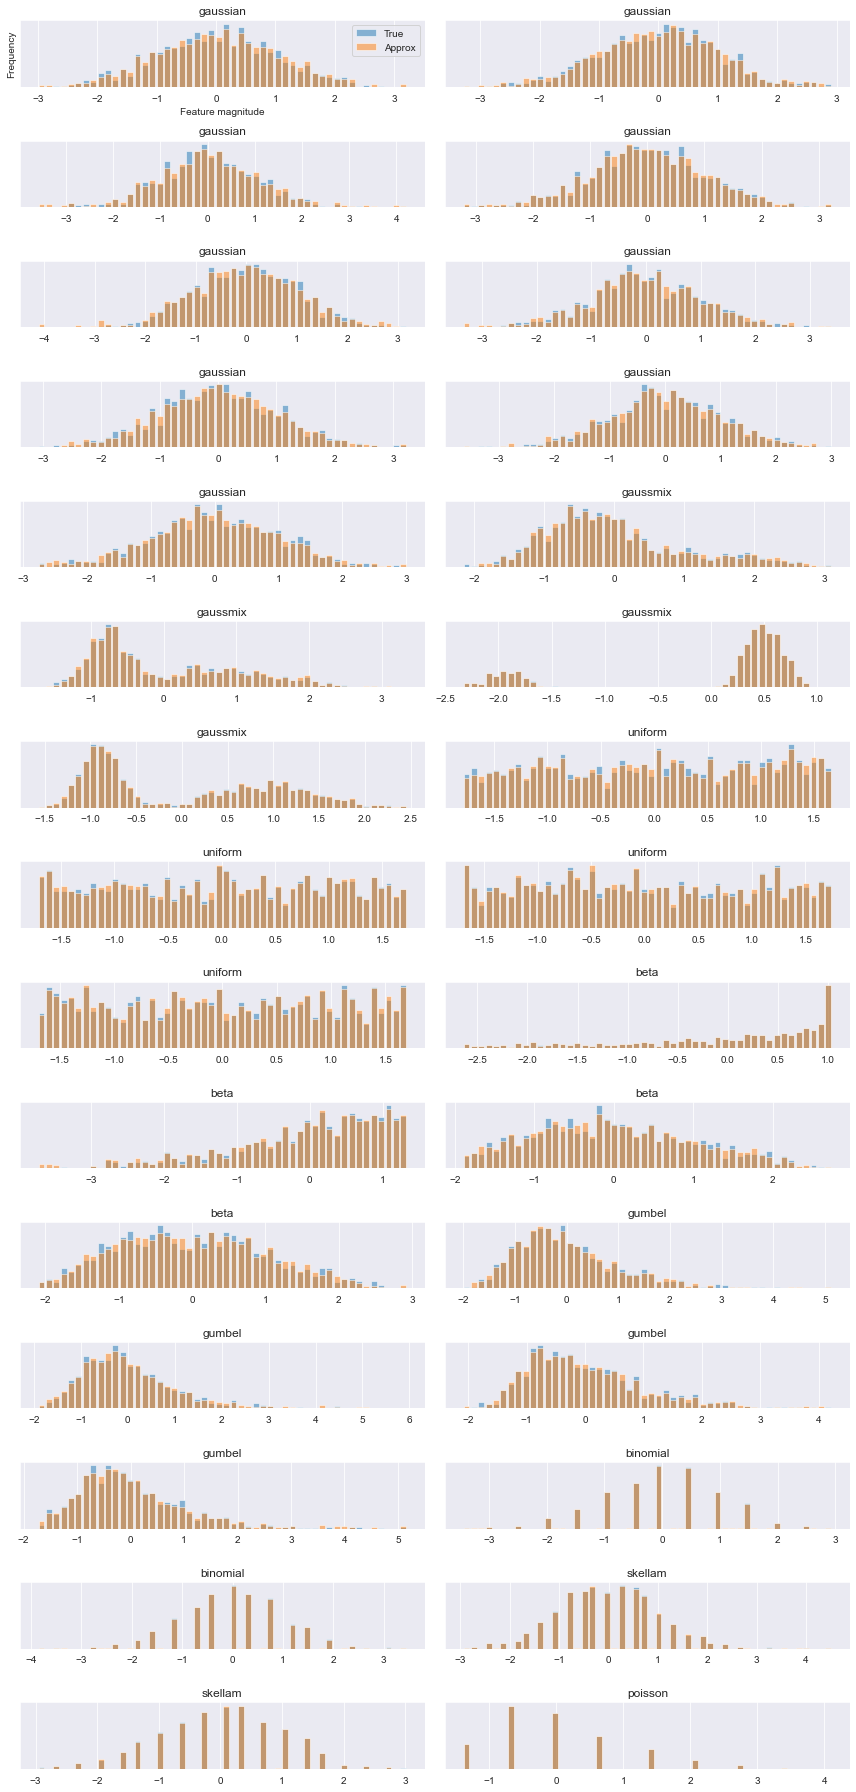

In [46]:
# also compare via plots
# plotting scaled structured data before and after pca approx
fig8, ax8 = plt.subplots(15, 2, figsize=(12,25))
ax = ax8.ravel()
for i in range(30):
    center = (epdf_bins[i][:-1] + epdf_bins[i][1:])/2.0
    width = (epdf_bins[i][1]-epdf_bins[i][0])*0.8
    ax[i].bar(center, x_s_epdf[:, i], alpha=0.5,width=width)
    ax[i].bar(center, x_s_approx[:, i], alpha=0.5,width=width)
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['True', 'Approx'], loc='best')
fig8.tight_layout()

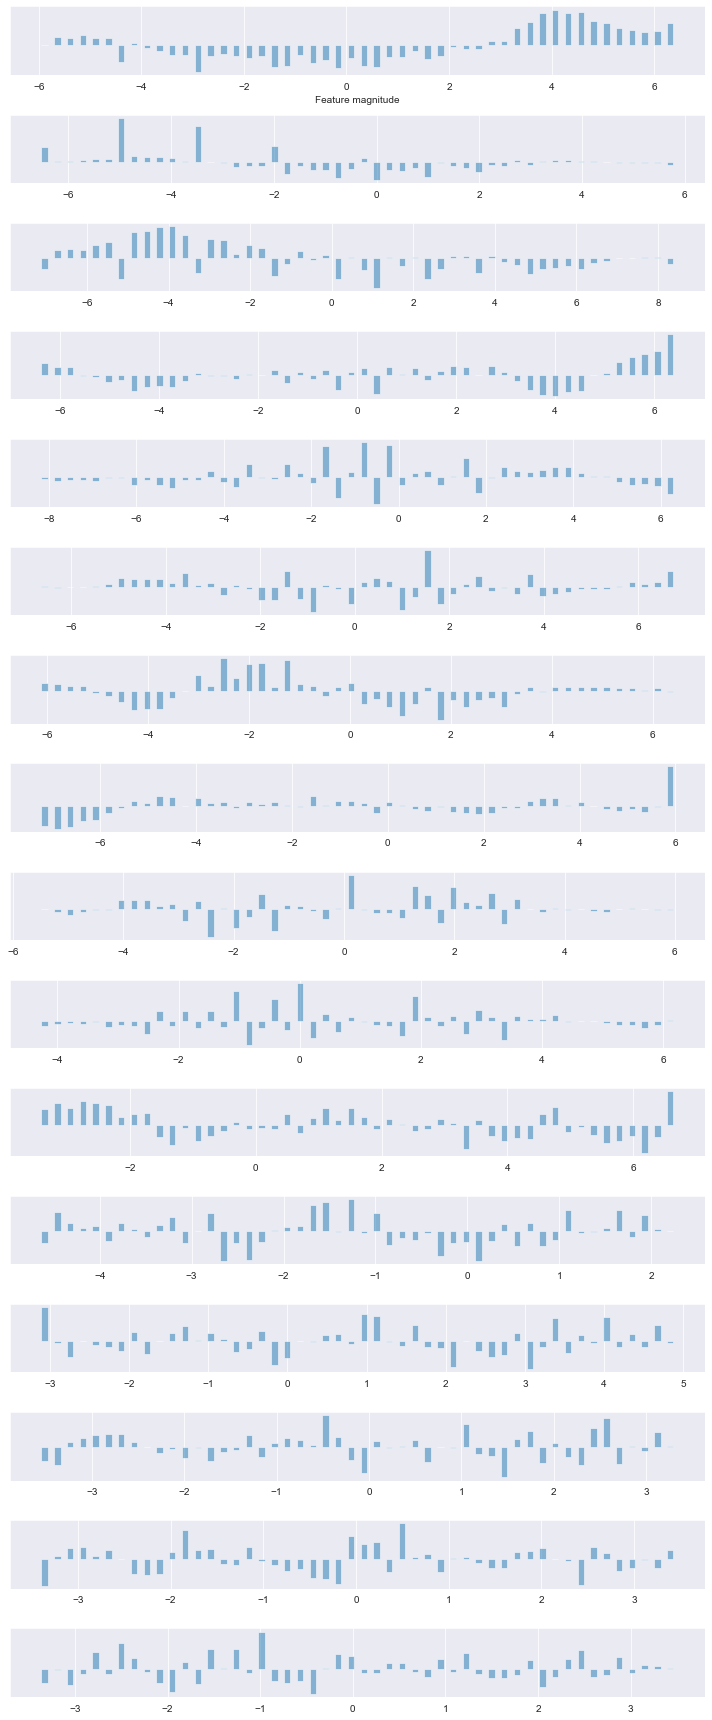

In [47]:
fig9, ax9 = plt.subplots(pca_s.n_components_, 1, figsize=(10,1.5*pca_s.n_components_))
ax = ax9.ravel()
# bar plot
for i in range(pca_s.n_components_):
    center = epdf_bins[i][:-1] + epdf_bins[i][1:]
    width = (epdf_bins[i][1]-epdf_bins[i][0])
    ax[i].bar(center, x_s_lat[:,i], alpha=0.5, width=width)
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
fig9.tight_layout()

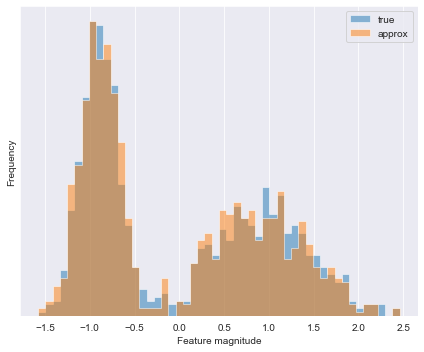

In [48]:
# generating pseudo-samples of approximated distributions with structured case

# for each epdf, create a dist object to sample from, then get num samples as from true samples
# working from: https://alpynepyano.github.io/healthyNumerics/posts/sampling_arbitrary_distributions_with_python.html
# generate ecdfs for each epdf approx
def ecdf_from_epdf(epdf_in, epdf_bins_in):
    """Generate an ecdf function based on an epdf"""
    ecdf = np.zeros_like(epdf_bins_in)
    ecdf[1:] = np.cumsum(epdf_in)
    ecdf = ecdf / ecdf[-1]
    return ecdf

# these are the y values of the ecdf, the x values are the epdf left bin edges
ecdf_approxs = []
for i in range(0,x_s_approx.shape[1]):
    ecdf_a = ecdf_from_epdf(x_s_approx[:,i],epdf_bins[i])
    ecdf_approxs.append(ecdf_a)
ecdf_approxs = np.array(ecdf_approxs)

# now use ecdfs to generate pseudo-samples from empirical pdfs
def get_epdf_sample(epdf_in, ecdf_in, epdf_bins_in):
    """Return a pseudo-sample from an epdf distribution"""
    # start from a random uniform sample
    ui = np.random.uniform(0.0,1.0)
    # get ecdf x and y index values around sample
    ind_hi = np.argmax(ecdf_in>=ui)
    ind_lo = np.argmax(ecdf_in>=ui)-1
    # get ecdf "y" values around ui
    x_hi = ecdf_in[ind_hi]
    x_lo = ecdf_in[ind_lo]
    # get ecdf "x" values around ui
    y_hi = epdf_bins_in[ind_hi]
    y_lo = epdf_bins_in[ind_lo]
    # fit linear model for continuous approx of ecdf "x" given ui as ecdf "y"
    slope = (y_hi-y_lo)/(x_hi-x_lo)
    intercept = y_hi - slope*x_hi
    sample = slope*ui + intercept
    return sample

# test sampling
samp_test = []
for i in range(0,1000):
    samp_test.append(get_epdf_sample(x_s_approx[:,12], ecdf_approxs[12],epdf_bins[12]))

# plot the test
fig11, ax11 = plt.subplots(1, 1, figsize=(6,5))
ax = ax11
_, bins = np.histogram(data_pca[:, 12], bins=50)
ax.hist(data_pca[:, 12], bins=bins, alpha=0.5, histtype='stepfilled',label="true")
ax.hist(np.array(samp_test), bins=bins, alpha=0.5, histtype='stepfilled',label="approx")
ax.set_yticks(())
ax.set_xlabel("Feature magnitude")
ax.set_ylabel("Frequency")
ax.legend()
fig11.tight_layout()

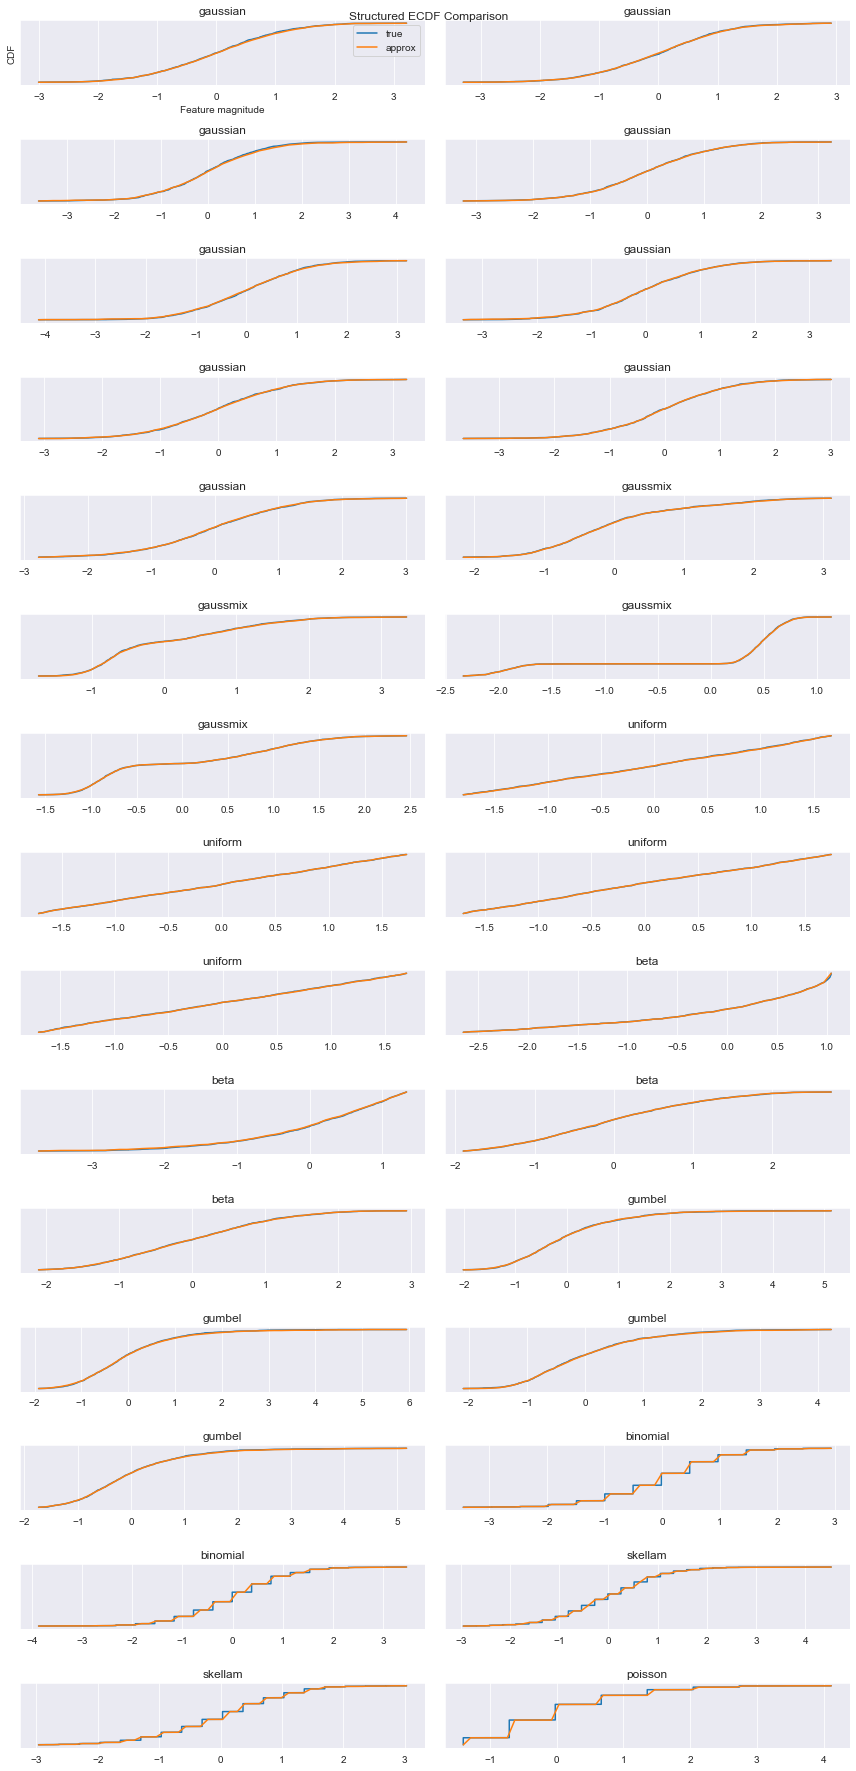

In [49]:
# approximate and true ecdf comparison
# plotting scaled data
fig13, ax13 = plt.subplots(15, 2, figsize=(12,25))
ax = ax13.ravel()
for i in range(30):
    ax[i].plot(x_t_ecdfs[i].x, x_t_ecdfs[i].y)
    ax[i].plot(epdf_bins[i], ecdf_approxs[i,:])
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig13.suptitle('Structured ECDF Comparison')
fig13.tight_layout()

In [50]:
# generate sets of approximated samples from approximate distributions
approx_samples = []
for i in range(0,x_s_approx.shape[1]):
    inter_samples = []
    for j in range(0,1000):
        inter_samples.append(get_epdf_sample(x_s_approx[:,i], ecdf_approxs[i], epdf_bins[i]))
    approx_samples.append(np.array(inter_samples))
approx_samples = np.array(approx_samples).T

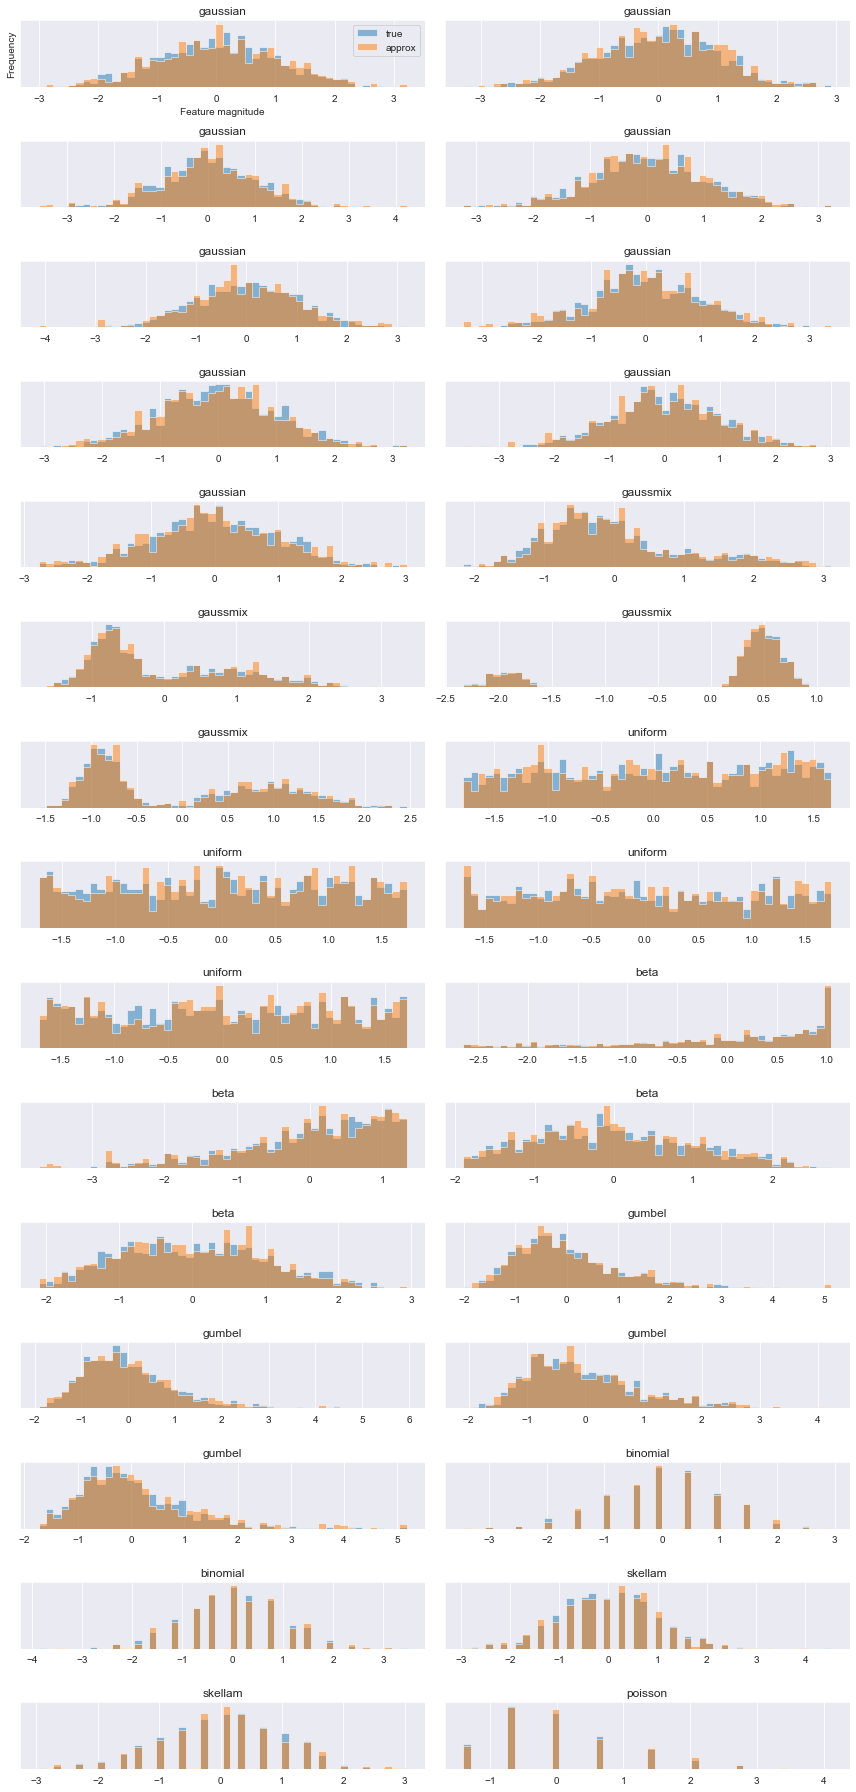

In [51]:
# compare samples from original distributions and approximate distributions
# take a look at plots of the samples (without scaling)
fig12, ax12 = plt.subplots(15, 2, figsize=(12,25))
ax = ax12.ravel()
for i in range(data_pca.shape[1]):
    _, bins = np.histogram(data_pca[:, i], bins=50)
    ax[i].hist(data_pca[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='true')
    ax[i].hist(approx_samples[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='approx')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend()
fig12.tight_layout()

In [54]:
# comparison of statistical distancing for structured and unstructred OR cases

# unstructured OR comparison between distributions
# initialize arrays for storage
ks_pval = []
ks_metr = []
js_dist = []
kl_divr = []
# make calculations
for i in range(0,len(x_t_ecdfs)):
    ks_m, ks_p = st.ks_2samp(x_true[:,i],x_approx[:,i])
    ks_pval.append(ks_p)
    ks_metr.append(ks_m)
    js_d = compute_js_dist(x_t_epdfs[i],x_a_epdfs[i])
    js_dist.append(js_d)
    kl_d = compute_kl_dist(x_t_epdfs[i],x_a_epdfs[i])
    kl_divr.append(kl_d)

In [55]:
# structured
ks_pval_s = []
ks_metr_s = []
js_dist_s = []
kl_divr_s = []
# make calculations
for i in range(0,x_s_approx.shape[1]):
    ks_m, ks_p = st.ks_2samp(x_true[:,i],approx_samples[:,i])
    ks_pval_s.append(ks_p)
    ks_metr_s.append(ks_m)
    js_d = compute_js_dist(x_t_epdfs[i],x_s_approx[:,i])
    js_dist_s.append(js_d)
    kl_d = compute_kl_dist(x_t_epdfs[i],x_s_approx[:,i])
    kl_divr_s.append(kl_d)

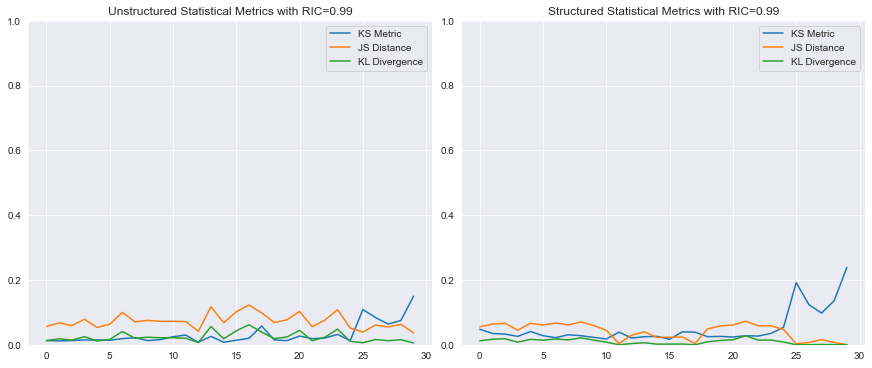

In [56]:
# plot
# plot the distance metrics
fig10, ax10 = plt.subplots(1,2,layout='constrained',figsize=(12,5))
ax = ax10.ravel()
ax[0].plot(range(0,x_true.shape[1]),ks_metr, label='KS Metric')
ax[0].plot(range(0,x_true.shape[1]),js_dist, label='JS Distance')
ax[0].plot(range(0,x_true.shape[1]),kl_divr, label='KL Divergence')
ax[0].set_ylim([0,1])
ax[0].legend()
ax[0].set_title('Unstructured Statistical Metrics with RIC='+str(req_ric))
ax[1].plot(range(0,x_true.shape[1]),ks_metr_s, label='KS Metric')
ax[1].plot(range(0,x_true.shape[1]),js_dist_s, label='JS Distance')
ax[1].plot(range(0,x_true.shape[1]),kl_divr_s, label='KL Divergence')
ax[1].set_ylim([0,1])
ax[1].set_title('Structured Statistical Metrics with RIC='+str(req_ric))
ax[1].legend()

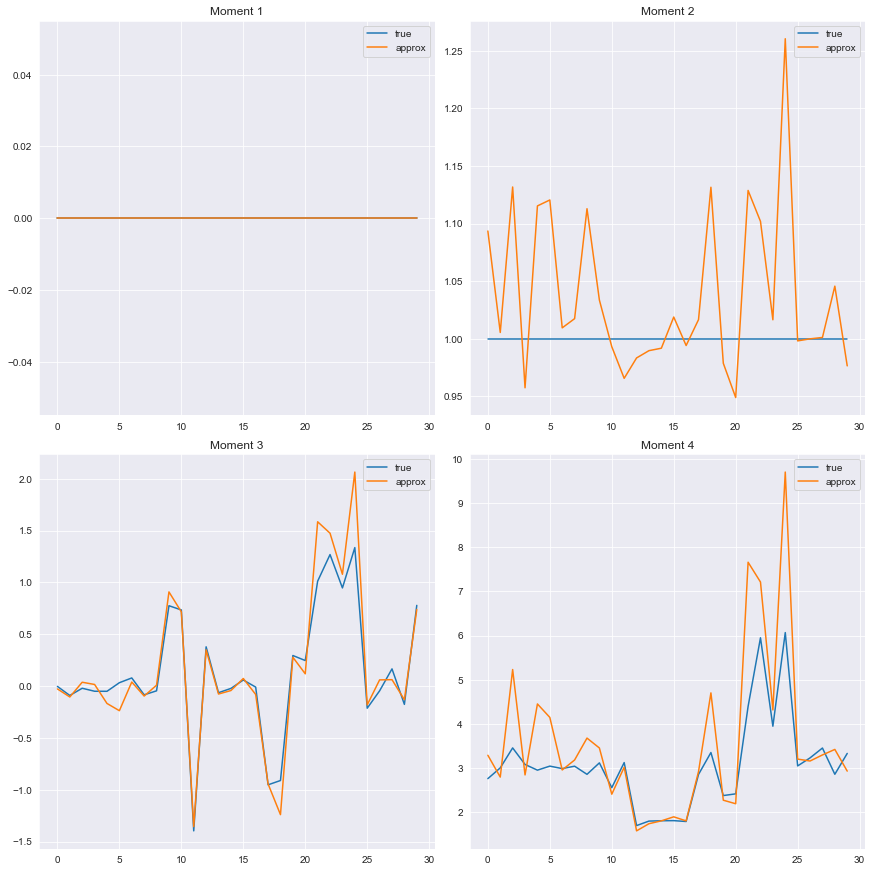

In [58]:
# comparison of moments, ranges, and quantiles before and after

moments = [1,2,3,4]

# true data and statistics
stats_data_true = data_pca
true_moments = st.moment(stats_data_true,moments,axis=0)

# approximate data and statistics
stats_data_aprx = approx_samples
aprx_moments = st.moment(stats_data_aprx, moments, axis=0)

# plot comparison
fig14, ax14 = plt.subplots(2,2,layout='constrained',figsize=(12,12))
ax = ax14.ravel()
for i in range(ax.shape[0]):
    ax[i].plot(range(0,true_moments.shape[1]),true_moments[i,:],label='true')
    ax[i].plot(range(0,aprx_moments.shape[1]),aprx_moments[i,:],label='approx')
    ax[i].legend()
    ax[i].set_title('Moment '+str(i+1))

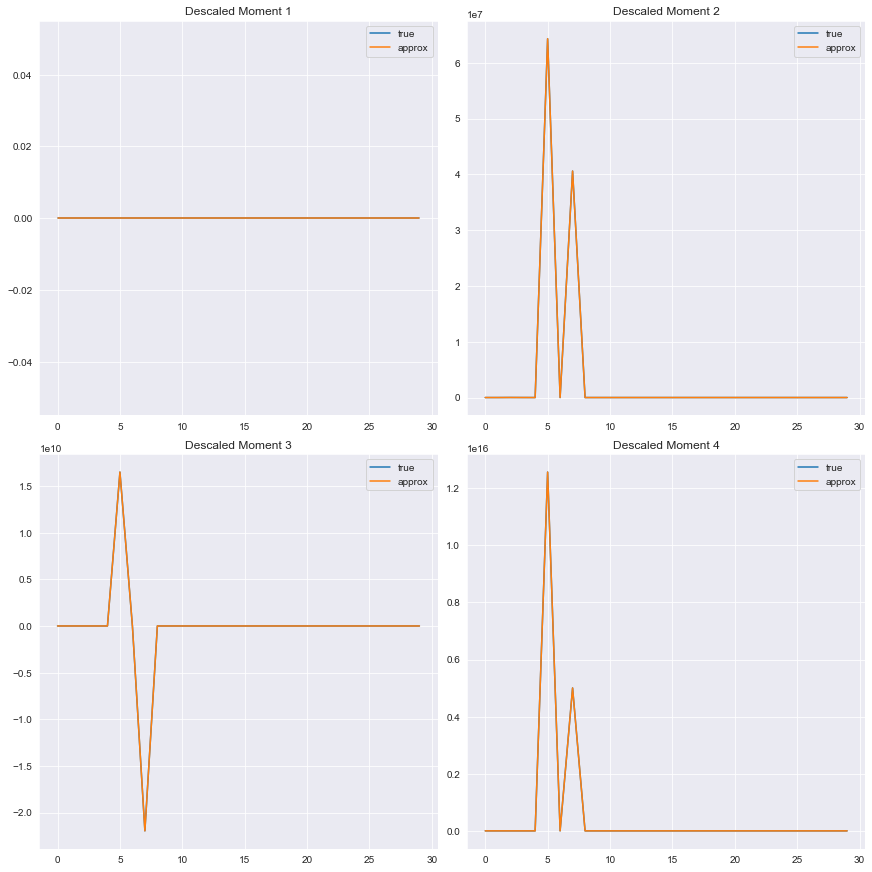

In [65]:
# comparison of de-scaled true and approximate data

# de-scaling the data
descaled_true = data.scaler.inverse_transform(stats_data_true)
descaled_aprx = data.scaler.inverse_transform(stats_data_aprx)

# moments
ds_true_moments = st.moment(descaled_true,moments,axis=0)
ds_aprx_moments = st.moment(descaled_aprx,moments,axis=0)

# moment percent error? range? quantiles?

# plot comparison
fig15, ax15 = plt.subplots(2,2,layout='constrained',figsize=(12,12))
ax = ax15.ravel()
for i in range(ax.shape[0]):
    ax[i].plot(range(0,ds_true_moments.shape[1]),ds_true_moments[i,:],label='true')
    ax[i].plot(range(0,ds_aprx_moments.shape[1]),ds_true_moments[i,:],label='approx')
    ax[i].legend()
    ax[i].set_title('Descaled Moment '+str(i+1))

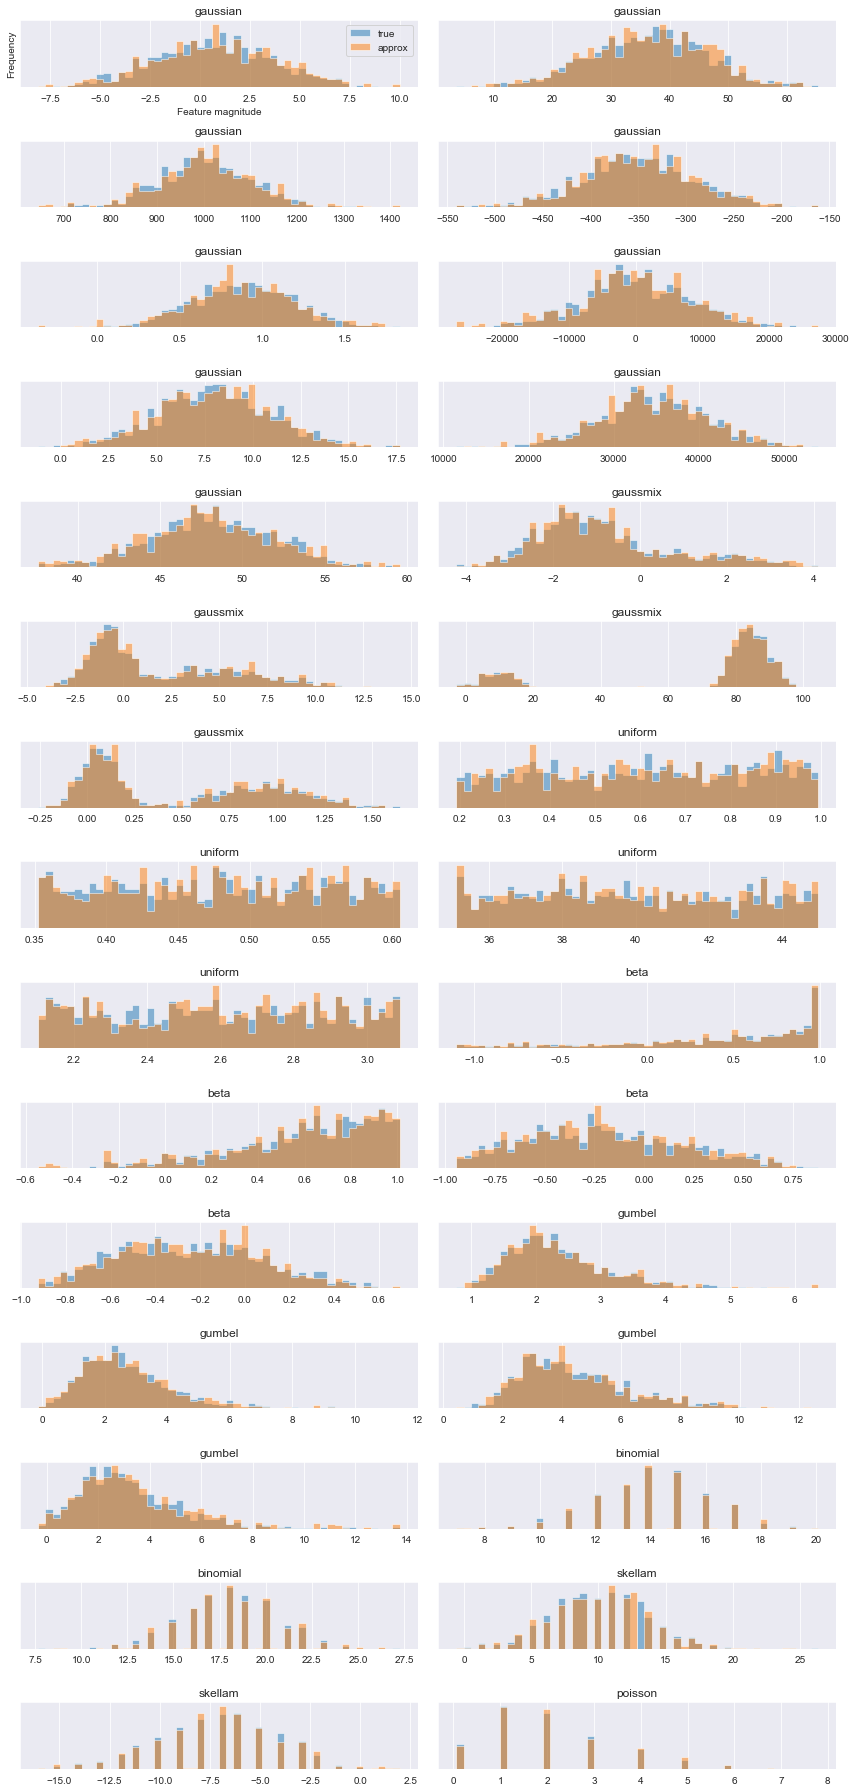

In [66]:
# comparison of de-scaled true and approximate data

# plotted histograms
fig16, ax16 = plt.subplots(15, 2, figsize=(12,25))
ax = ax16.ravel()
for i in range(data_pca.shape[1]):
    _, bins = np.histogram(descaled_true[:, i], bins=50)
    ax[i].hist(descaled_true[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='true')
    ax[i].hist(descaled_aprx[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='approx')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend()
fig16.tight_layout()